In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件
df = pd.read_csv('merged_metric_results.csv')

# 显示前几行数据以确认读取正确
# print(df.head())

# 检查 'value' 列的数据类型
# print(df['value'].dtype)

# 将 'value' 列转换为数值类型
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# 定义要统计的 metric_names
metrics_to_sum = [
    # 在测量时间段内，SM 运行的总时钟周期数。作为基准，用于计算其他指标的百分比或比率
    'sm__cycles_elapsed.avg',

    # 在测量时间段内，SM 实际执行指令的时钟周期数。它可以用来衡量 SM 的利用率
    'sm__cycles_active.avg',

    # GPU 流多处理器（SM）处于活动状态的时钟周期数占总时钟周期数的百分比，表示SM利用率
    'sm__cycles_active.avg.pct_of_peak_sustained_elapsed',

    # SM 中张量核心（Tensor Cores）处于活动状态的时钟周期数的平均值
    'sm__pipe_tensor_cycles_active.avg',

    # SM 中张量核心（Tensor Cores）处于活动状态的时钟周期数占 SM 活动时钟周期数的百分比，衡量tensor core的利用率
    'sm__pipe_tensor_cycles_active.avg.pct_of_peak_sustained_active',

    'smsp__pipe_tensor_cycles_active.sum',
    'smsp__pipe_tensor_cycles_active.avg'
]

# 计算每个 metric_name 的 value 列的总和或平均值
results = {}
for metric in metrics_to_sum:
    filtered_df = df[df['metric_name'] == metric]
    
    if metric in ['sm__cycles_active.avg.pct_of_peak_sustained_elapsed', 'sm__pipe_tensor_cycles_active.avg.pct_of_peak_sustained_active']:
        # 计算平均值
        total_avg = filtered_df['value'].mean()
        results[metric] = total_avg
    else:
        # 计算总和
        total_sum = filtered_df['value'].sum()
        results[metric] = total_sum

# 打印每个 metric_name 的 value 列的总和或平均值
for metric, value in results.items():
    if metric in ['sm__cycles_active.avg.pct_of_peak_sustained_elapsed', 'sm__pipe_tensor_cycles_active.avg.pct_of_peak_sustained_active']:
        print(f'Average value for metric_name "{metric}": {value}')
    else:
        print(f'Total sum of values for metric_name "{metric}": {value}')


In [ ]:
import pandas as pd
import numpy as np

# 读取 CSV 文件
df = pd.read_csv('merged_metric_results.csv')

# 将 'value' 列转换为数值类型
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# 创建 label 列
df['label'] = df.apply(lambda row: f"{row['session_id']},{row['range_id']},{row['launchId']},{row['kernel']}", axis=1)

# 提取所需的指标数据
metrics_to_extract = [
    'sm__cycles_active.avg',
    'sm__cycles_elapsed.avg',
    'sm__cycles_active.avg.pct_of_peak_sustained_elapsed'
]

# 过滤出需要的指标
filtered_df = df[df['metric_name'].isin(metrics_to_extract)]

# 重命名列以便于后续处理
filtered_df = filtered_df.rename(columns={'value': 'metric_value'})

# 转换为透视表，使每个 label 对应的 metric_name 和 metric_value 在同一行
pivot_df = filtered_df.pivot_table(index=['session_id', 'range_id', 'launchId', 'kernel', 'label'], 
                                   columns='metric_name', values='metric_value').reset_index()

# 计算 pct 值
pivot_df['pct'] = (pivot_df['sm__cycles_active.avg'] / pivot_df['sm__cycles_elapsed.avg']) * 100

# 确保 pct 的小数点后的位数与 pct_peak 一致
def format_pct(pct, pct_peak):
    # 获取 pct_peak 的小数点后的位数
    decimal_places = len(str(pct_peak).split('.')[1]) if '.' in str(pct_peak) else 0
    return np.format_float_positional(pct, precision=decimal_places, trim='-')

# 添加 pct_peak 列
pivot_df['pct_peak'] = pivot_df['sm__cycles_active.avg.pct_of_peak_sustained_elapsed']

# 格式化 pct 列
pivot_df['pct'] = pivot_df.apply(lambda row: format_pct(row['pct'], row['pct_peak']), axis=1)

# 比较 pct 和 pct_peak
pivot_df['equal'] = pivot_df.apply(lambda row: row['pct_peak'] == float(row['pct']), axis=1)

# 重新组织列顺序
pivot_df = pivot_df[['session_id', 'range_id', 'launchId', 'kernel', 'label', 'pct_peak', 'pct', 'equal']]

# 保存结果到 CSV 文件
output_file = 'comparison_results.csv'
pivot_df.to_csv(output_file, index=False)

print(f"Results saved to {output_file}")

# 上述代码用于验证，在当前场景下
# sm__cycles_active.avg.pct_of_peak_sustained_elapsed = sm__cycles_active.avg / sm__cycles_elapsed.avg
# 这就说明，在当前场景下，默认cycles跑满的情况下，SM的利用率峰值可以达到100%

In [ ]:
import json

# 创建字典描述简化前后的 kernel name 对应关系
kernel_name_mapping = {
    "_ZN14cask__5x_cudnn20computeOffsetsKernelILb0ELb0EEEvNS_20ComputeOffsetsParamsE": "computeOffsetsKernel",
    "_5x_cudnn_ampere_scudnn_128x64_relu_medium_nn_v1": "ampere_scudnn_128x64_relu",
    "_ZN2at6native18elementwise_kernelILi128ELi2EZNS0_22gpu_kernel_impl_nocastINS0_15CUDAFunctor_addIfEEEEvRNS_18TensorIteratorBaseERKT_EUliE_EEviT1_": "elementwise_kernel_gpu_kernel_impl_nocast",
    "_ZN2at6native29vectorized_elementwise_kernelILi4ENS0_21CUDAFunctorOnSelf_addIlEENS_6detail5ArrayIPcLi2EEEEEviT0_T1_": "vectorized_elementwise_kernel",
    "_ZN5cudnn25bn_fw_tr_1C11_kernel_NCHWIffiLi512ELb1ELi1ELb1EEEv17cudnnTensorStructPKT_S1_PS2_PKT0_S8_S6_S6_PS6_S9_S9_S9_S6_S6_": "bn_fw_tr_1C11_kernel_NCHW_cudnnTensorStruct",
    "_ZN2at6native29vectorized_elementwise_kernelILi4EZZZNS0_49_GLOBAL__N__d2ba64fb_16_TensorCompare_cu_71e06f4e19launch_clamp_scalarERNS_18TensorIteratorBaseEN3c106ScalarES6_NS0_6detail11ClampLimitsEENKUlvE_clEvENKUlvE5_clEvEUlfE_NS_6detail5ArrayIPcLi2EEEEEviT0_T1_": "vectorized_elementwise_kernel_TensorCompare_cu_launch_clamp_scalar",
    "_ZN5cudnn8winograd27generateWinogradTilesKernelILi0EffEEvNS0_27GenerateWinogradTilesParamsIT0_T1_EE": "generateWinogradTilesKernel",
    "_5x_cudnn_ampere_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148t_nt_v1": "ampere_scudnn_winograd_128x128_relu",
    "_ZN2at6native52_GLOBAL__N__e57809e0_19_DilatedMaxPool2d_cu_6258b57421max_pool_forward_nchwIfEEviPKT_llliiiiiiiiiiPS3_Pl": "max_pool_forward_nchw",
    "_ZN5cudnn19engines_precompiled16nchwToNhwcKernelIfffLb0ELb1EL21cudnnKernelDataType_t2EEEvNS0_18nchw2nhwc_params_tIT1_EEPKT_PT0_": "engines_precompiled_nchwToNhwcKernel_Lb0ELb1E",
    "_ZN5cudnn24bn_fw_tr_1C11_singlereadIfLi512ELb1ELi1ELi2ELi0EEEvNS_18bn_fw_tr_1C11_argsIT_EE": "bn_fw_tr_1C11_singleread",
    "_ZN17cutlass__5x_cudnn6KernelI66cutlass_tensorop_s1688fprop_optimized_tf32_128x64_16x6_nhwc_align4EEvNT_6ParamsE": "Kernel_fprop_optimized16x6",
    "_ZN5cudnn19engines_precompiled16nhwcToNchwKernelIfffLb1ELb0EL21cudnnKernelDataType_t0EEEvNS0_18nhwc2nchw_params_tIT1_EEPKT_PT0_": "engines_precompiled_nhwcToNchwKernel_Lb1ELb0E",
    "_ZN17cutlass__5x_cudnn6KernelI66cutlass_tensorop_s1688fprop_optimized_tf32_128x64_32x3_nhwc_align4EEvNT_6ParamsE": "Kernel_fprop_optimized32x3",
    "_ZN8internal5gemvx6kernelIiiffffLb0ELb1ELb1ELb0ELi7ELb0E16cublasGemvParamsI30cublasGemvTensorStridedBatchedIKfES5_S3_IfEfEEENSt9enable_ifIXntT5_EvE4typeET11_": "gemvx6kernel",
    "_ZN2at6native43_GLOBAL__N__50f1b6c4_10_Dropout_cu_0e96ed3824fused_dropout_kernel_vecIffjLi1ELi4EbEEvNS_4cuda6detail10TensorInfoIKT_T1_EENS5_IS6_S8_EENS5_IT4_S8_EES8_T0_NS_15PhiloxCudaStateE": "fused_dropout_kernel_vec",
    "_Z17gemv2T_kernel_valIiiffffLi128ELi16ELi4ELi4ELb0ELb1E16cublasGemvParamsI30cublasGemvTensorStridedBatchedIKfES3_S1_IfEfEEvT11_T4_S7_": "gemv2T_kernel_val",
    "sm86_xmma_fprop_implicit_gemm_tf32f32_tf32f32_f32_nhwckrsc_nchw_tilesize256x128x32_stage2_warpsize4x2x1_g1_tensor16x8x8_alignc4_execute_kernel__5x_cudnn": "sm86_xmma_fprop_implicit_gemm_tile256x128x32_stage2_warp4x2x1_execute_kernel",
    "sm86_xmma_fprop_implicit_gemm_tf32f32_tf32f32_f32_nhwckrsc_nchw_tilesize128x128x16_stage3_warpsize2x2x1_g1_tensor16x8x8_alignc4_execute_kernel__5x_cudnn": "sm86_xmma_fprop_implicit_gemm_tile128x128x16_stage3_warp2x2x1_execute_kernel",
    "sm86_xmma_fprop_implicit_gemm_indexed_tf32f32_tf32f32_f32_nhwckrsc_nhwc_tilesize128x64x32_stage4_warpsize2x2x1_g1_tensor16x8x8_execute_kernel__5x_cudnn": "sm86_xmma_fprop_implicit_gemm_indexed_tile128x64x32_stage4_warp2x2x1_execute_kernel"
}

# 将字典转换为 JSON 格式并写入文件
with open('kernel_name_mapping.json', 'w') as json_file:
    json.dump(kernel_name_mapping, json_file, indent=4)

print("JSON file has been created successfully.")


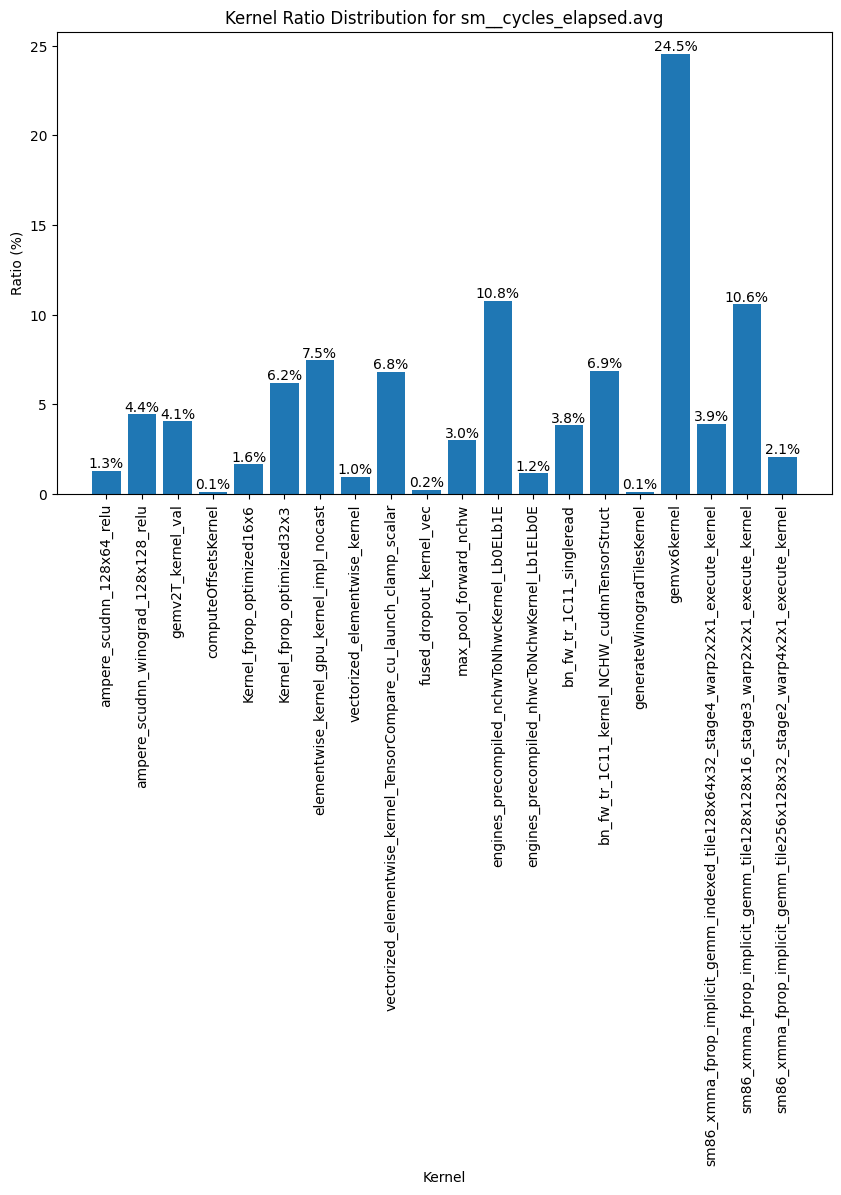

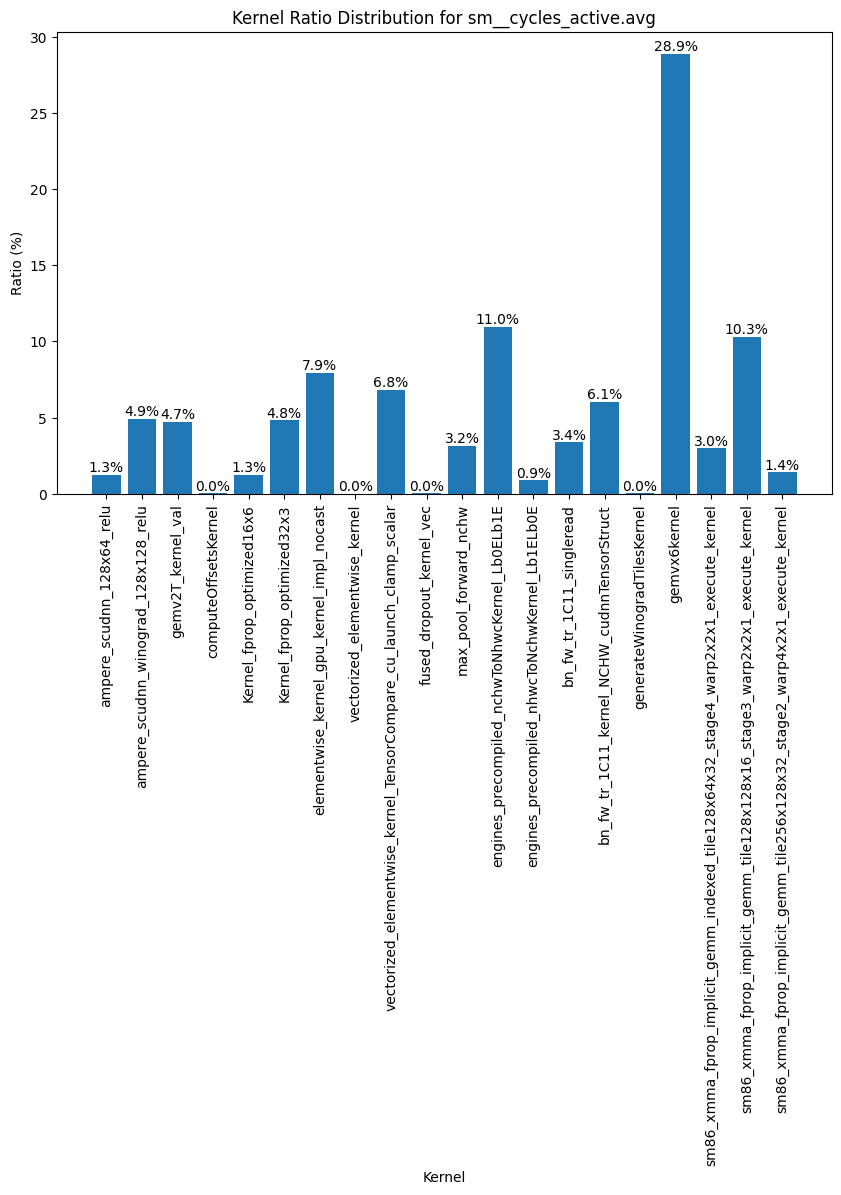

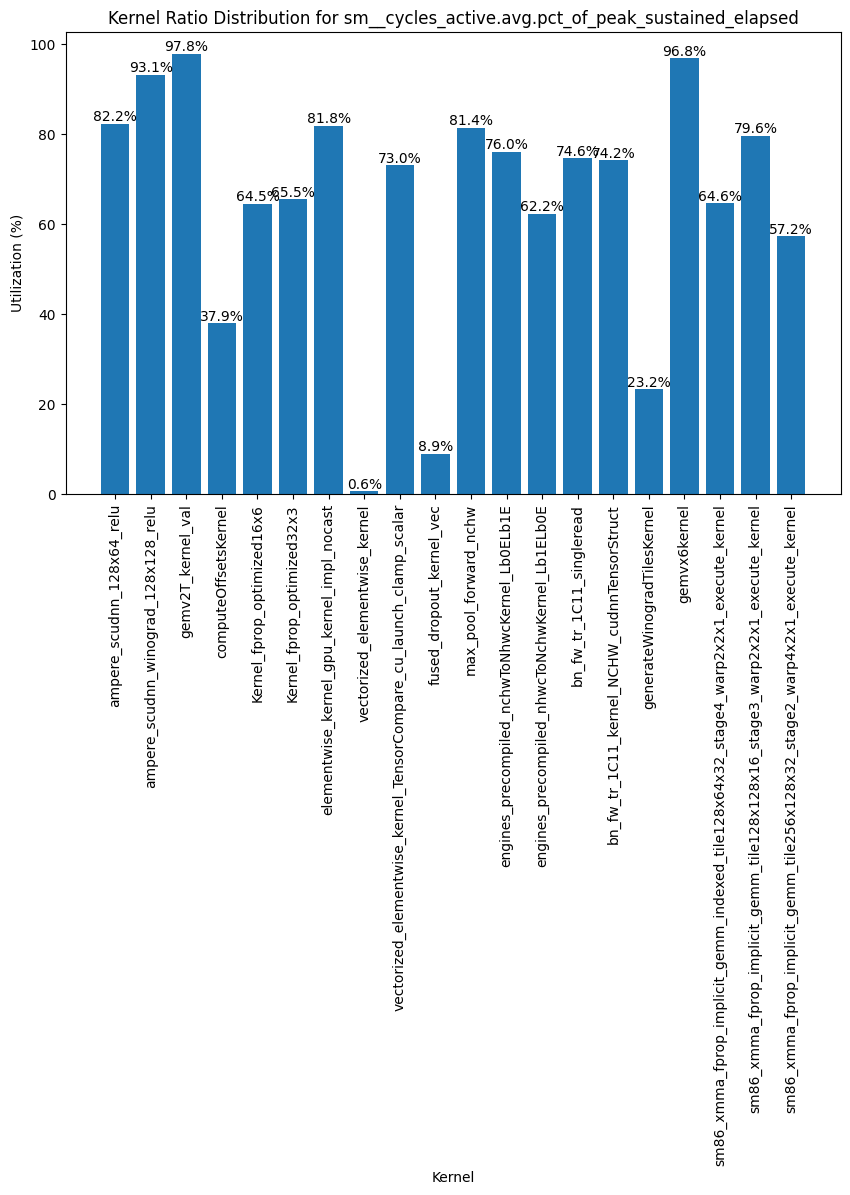

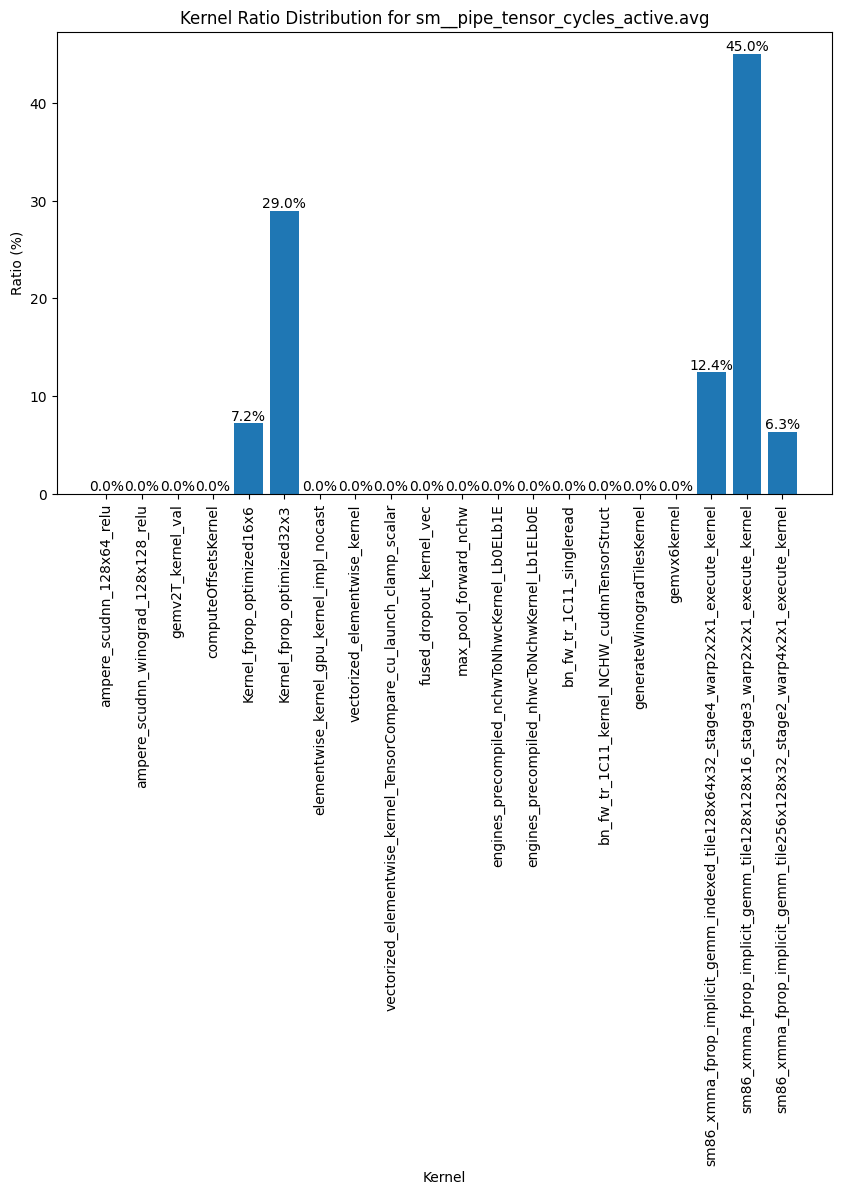

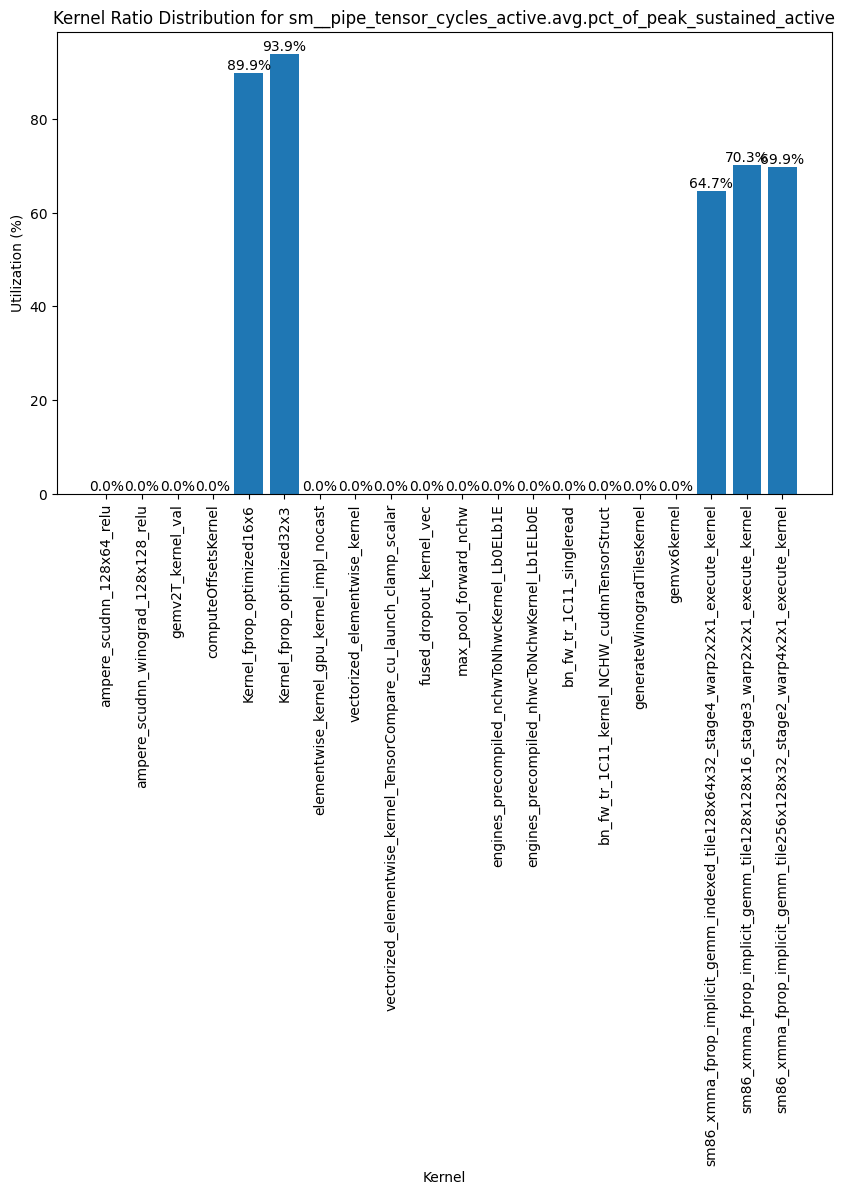

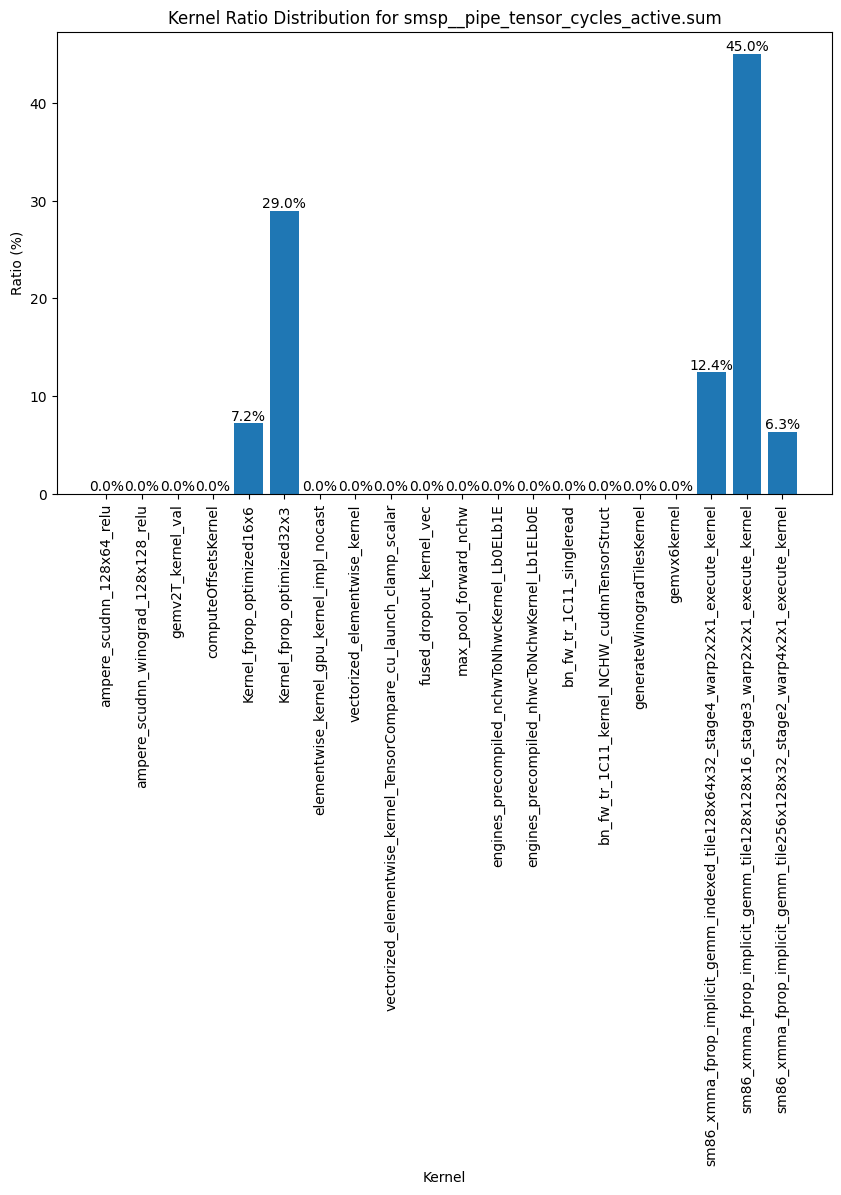

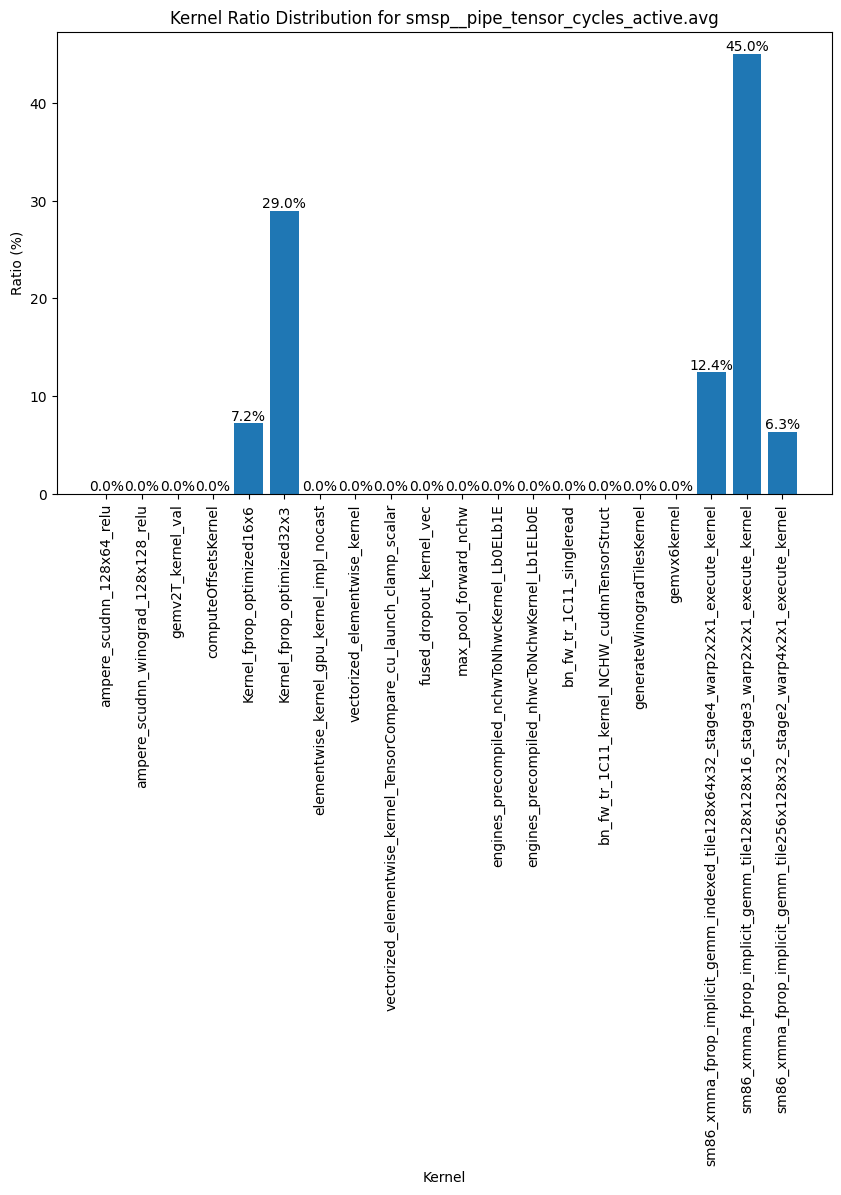

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json

# 读取 CSV 文件
df = pd.read_csv('merged_metric_results.csv')

# 将 'value' 列转换为数值类型
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# 定义要统计的 metric_names
metrics_to_sum = [
    # 含义: 表示 GPU 流多处理器（Streaming Multiprocessor, SM）在测量期间经历的总时钟周期数的平均值。
    # 用途: 用于衡量 GPU 在执行任务时的时间长度。这个指标可以帮助理解 GPU 的整体活动时间。
    'sm__cycles_elapsed.avg',

    # 含义: 表示 GPU 流多处理器（SM）在测量期间处于活动状态的时钟周期数的平均值。
    # 用途: 用于衡量 GPU 在执行任务时实际工作的时钟周期数。这个指标可以帮助理解 GPU 的利用率。
    'sm__cycles_active.avg',

    # 含义: 表示 GPU 流多处理器（SM）处于活动状态的时钟周期数占总时钟周期数的百分比，表示 SM 利用率。
    # 用途: 用于衡量 GPU 的利用率相对于其峰值性能的百分比。这个指标可以帮助理解 GPU 的效率和利用率。
    'sm__cycles_active.avg.pct_of_peak_sustained_elapsed',

    # 含义: 表示 GPU 流多处理器（SM）中张量核心（Tensor Cores）处于活动状态的时钟周期数的平均值。
    # 用途: 用于衡量 Tensor Cores 在执行任务时实际工作的时钟周期数。这个指标可以帮助理解 Tensor Cores 的利用率。
    'sm__pipe_tensor_cycles_active.avg',

    # 含义: 表示 GPU 流多处理器（SM）中张量核心（Tensor Cores）处于活动状态的时钟周期数占总活动时钟周期数的百分比，表示 Tensor Cores 的利用率。
    # 用途: 用于衡量 Tensor Cores 的利用率相对于其峰值性能的百分比。这个指标可以帮助理解 Tensor Cores 的效率和利用率。
    'sm__pipe_tensor_cycles_active.avg.pct_of_peak_sustained_active',

    # 含义: 表示 GPU 流多处理器（SM）中张量核心（Tensor Cores）处于活动状态的时钟周期数的总和。
    # 用途: 用于衡量 Tensor Cores 在整个测量期间实际工作的总时钟周期数。这个指标可以帮助理解 Tensor Cores 的总体活动情况。
    'smsp__pipe_tensor_cycles_active.sum',

    # 含义: 表示 GPU 流多处理器（SM）中张量核心（Tensor Cores）处于活动状态的时钟周期数的平均值。
    # 用途: 用于衡量 Tensor Cores 在执行任务时实际工作的时钟周期数的平均值。这个指标可以帮助理解 Tensor Cores 的平均利用率。
    'smsp__pipe_tensor_cycles_active.avg'
]

# 读取 kernel_name_mapping.json 文件
with open('kernel_name_mapping.json', 'r') as json_file:
    kernel_name_mapping = json.load(json_file)

# 创建 label 列
df['label'] = df.apply(lambda row: f"{row['session_id']},{row['range_id']},{row['kernel']}", axis=1)

# 指定保存图表的文件夹
output_folder = 'charts'
os.makedirs(output_folder, exist_ok=True)  # 创建文件夹（如果不存在）

# 存储每个 metric 的总和或平均值
results = {}

# 计算每个 metric 的总和或平均值
for metric in metrics_to_sum:
    filtered_df = df[df['metric_name'] == metric]
    
    if metric in ['sm__cycles_active.avg.pct_of_peak_sustained_elapsed', 'sm__pipe_tensor_cycles_active.avg.pct_of_peak_sustained_active']:
        # 计算平均值
        total_avg = filtered_df['value'].mean()
        results[metric] = total_avg
    else:
        # 计算总和
        total_sum = filtered_df['value'].sum()
        results[metric] = total_sum

# 绘制每种 metric_name 的柱状图
for metric in metrics_to_sum:
    # 过滤当前 metric_name 的数据
    filtered_df = df[df['metric_name'] == metric]
    
    # 计算每个 kernel 的 value 总和
    if metric in ['sm__cycles_active.avg.pct_of_peak_sustained_elapsed', 'sm__pipe_tensor_cycles_active.avg.pct_of_peak_sustained_active']:
        # 计算每个 kernel 出现的次数
        kernel_counts = filtered_df['kernel'].value_counts().reset_index()
        kernel_counts.columns = ['kernel', 'count']
        
        # 计算每个 kernel 的 value 总和
        kernel_sums = filtered_df.groupby('kernel')['value'].sum().reset_index()
        
        # 合并两个 DataFrame
        kernel_data = pd.merge(kernel_sums, kernel_counts, on='kernel')
        
        # 计算每个 kernel 的平均值
        kernel_data['ratio'] = kernel_data['value'] / kernel_data['count']
    else:
        # 计算每个 kernel 的 value 总和
        kernel_sums = filtered_df.groupby('kernel')['value'].sum().reset_index()
        
        # 计算每个 kernel 的 ratio
        if results[metric] > 0:
            kernel_sums['ratio'] = kernel_sums['value'] / results[metric] * 100
        else:
            kernel_sums['ratio'] = 0.0
    
    # 提取 labels 和 ratios
    labels = kernel_sums['kernel']
    ratios = kernel_sums['ratio'] if metric not in ['sm__cycles_active.avg.pct_of_peak_sustained_elapsed', 'sm__pipe_tensor_cycles_active.avg.pct_of_peak_sustained_active'] else kernel_data['ratio']
    
    # 处理 NaN 值
    valid_indices = ~ratios.isna()
    valid_labels = labels[valid_indices]
    valid_ratios = ratios[valid_indices]
    
    # 简化 kernel 名称
    simplified_labels = [kernel_name_mapping.get(label, label) for label in valid_labels]
    
    # 绘制柱状图
    if not valid_ratios.empty and valid_ratios.sum() > 0:
        plt.figure(figsize=(10, 6))
        bars = plt.bar(simplified_labels, valid_ratios)
        plt.title(f'Kernel Ratio Distribution for {metric}')
        plt.xlabel('Kernel')
        plt.ylabel('Ratio (%)' if metric not in ['sm__cycles_active.avg.pct_of_peak_sustained_elapsed', 'sm__pipe_tensor_cycles_active.avg.pct_of_peak_sustained_active'] else 'Utilization (%)')
        plt.xticks(rotation=90)
        
        # 在柱状图顶部显示实际的占比
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')
        
        # 保存柱状图到指定文件夹
        bar_chart_path = os.path.join(output_folder, f'bar_{metric}.png')
        plt.savefig(bar_chart_path)
        plt.show()
    else:
        print(f"No valid data to plot for metric: {metric}")


分析sm_cycle_active.avg和sm_cycle_elapsed.avg的相关性

Correlation between sm__cycles_active.avg and sm__cycles_elapsed.avg: 0.9964


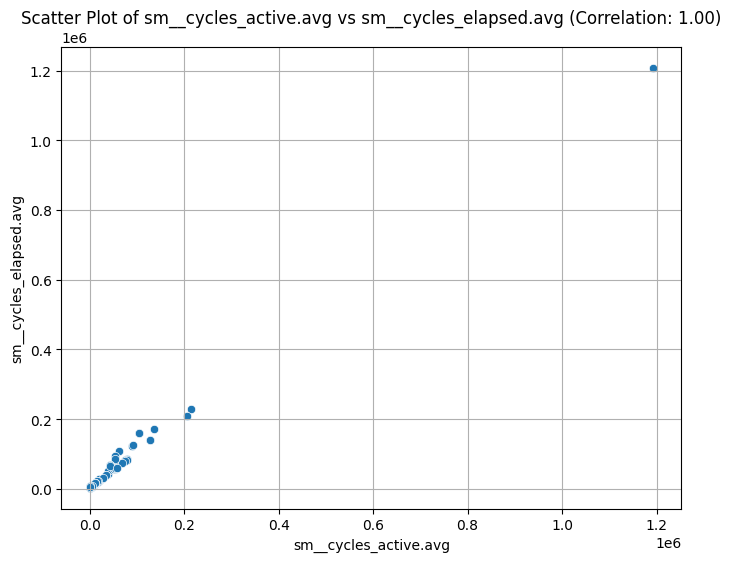

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# 读取 CSV 文件
df = pd.read_csv('merged_metric_results.csv')

# 将 'value' 列转换为数值类型
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# 提取 sm__cycles_active.avg 和 sm__cycles_elapsed.avg 的数据
active_df = df[df['metric_name'] == 'sm__cycles_active.avg']
elapsed_df = df[df['metric_name'] == 'sm__cycles_elapsed.avg']

# 确保两个 DataFrame 的行数相同
if len(active_df) != len(elapsed_df):
    print("The number of rows for sm__cycles_active.avg and sm__cycles_elapsed.avg are different. Please check the data.")
else:
    # 重置索引
    active_df = active_df.reset_index(drop=True)
    elapsed_df = elapsed_df.reset_index(drop=True)
    
    # 计算相关系数
    correlation = active_df['value'].corr(elapsed_df['value'])
    print(f"Correlation between sm__cycles_active.avg and sm__cycles_elapsed.avg: {correlation:.4f}")
    
    # 绘制散点图
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=active_df['value'], y=elapsed_df['value'])
    plt.title(f'Scatter Plot of sm__cycles_active.avg vs sm__cycles_elapsed.avg (Correlation: {correlation:.2f})')
    plt.xlabel('sm__cycles_active.avg')
    plt.ylabel('sm__cycles_elapsed.avg')
    plt.grid(True)
    
    # 保存散点图
    output_folder = 'charts'
    os.makedirs(output_folder, exist_ok=True)  # 创建文件夹（如果不存在）
    scatter_plot_path = os.path.join(output_folder, 'scatter_sm_cycles_active_vs_elapsed.png')
    plt.savefig(scatter_plot_path)
    plt.show()
